BERT: applying the **bidirectional** training of Transformer, a popular attention model, to language modelling.

spaCy, NLTK: libraries for Natural Language Processing 

# Knowledge Graphs

## 1. Import dependencies and load dataset

In [ ]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [ ]:
# import wikipedia sentences
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/Colab Notebooks')

candidate_sentences = pd.read_csv("wiki_sentences_v2.csv")
candidate_sentences.shape


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(4318, 1)

## 2. Text Segmentation (Split the text document or article into sentences)

In [ ]:
candidate_sentences['sentence'].sample(5)

2273       a soundtrack typically contains instrumentation or alternatively a film score.
2115                    a clockwork orange was a box-office success in the united states.
1583    it was then owned and operated by david horsley and his brother, william horsley.
1400                                                           it's filled with ambition.
1949                                    principal photography began on 28 september 2014.
Name: sentence, dtype: object

In [ ]:
doc = nlp("the drawdown process is governed by astm standard d823")

for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
drawdown ... amod
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... amod
d823 ... pobj


## 3. Entities Extraction

In [ ]:
def get_entities(sent):
  # chunk 1
  # Define a few empty variables in this chunk. 
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3 : Here, if the token is the subject, then it will be captured as the first entity in the ent1 variable.
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4: Here, if the token is the object, then it will be captured as the second entity in the ent2 variable. 
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text


  return [ent1.strip(), ent2.strip()]

In [ ]:
# test the function

get_entities("the film had 200 patents")

['film', '200  patents']

In [ ]:
#extract entity pairs

entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:39<00:00, 108.00it/s]


In [ ]:
entity_pairs[10:20]

[['we', 'tests'],
 ['m global', 'international sales rights'],
 ['robbie robertson', 'soundtrack'],
 ['it', 'original music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['', 'military  arrest'],
 ['train', 'vuk'],
 ['telepath', 'gallio'],
 ['singer', 'men']]

## 4. Relations Extraction

To build a knowledge graph, we need edges to connect the nodes (entities) to one another. These edges are the relations between a pair of nodes.
Hypothesis is that the predicate is  the main verb in a sentence.

In [ ]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [ ]:
get_relation("John completed the task")

'completed'

In [ ]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 4318/4318 [00:37<00:00, 113.70it/s]


In [ ]:
pd.Series(relations).value_counts()[:50]

is               370
was              297
released on       87
include           73
were              71
are               71
released          40
's                38
composed by       35
became            31
has               31
have              31
become            29
released in       27
included          26
produced          22
called            22
made              20
considered        20
had               20
been              18
be                18
scheduled         17
used              17
directed by       16
stars             16
written by        15
wrote             14
produced by       14
hired             14
set               14
received          13
went              13
introduced in     13
wanted            12
won               11
began             11
began in          11
sold              10
gave              10
features          10
produced in        9
directed           9
shot in            9
includes           9
known as           9
reported           9
used in      

## 5. Build Knowledge Graph

In [ ]:
#create dataframe

# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [ ]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

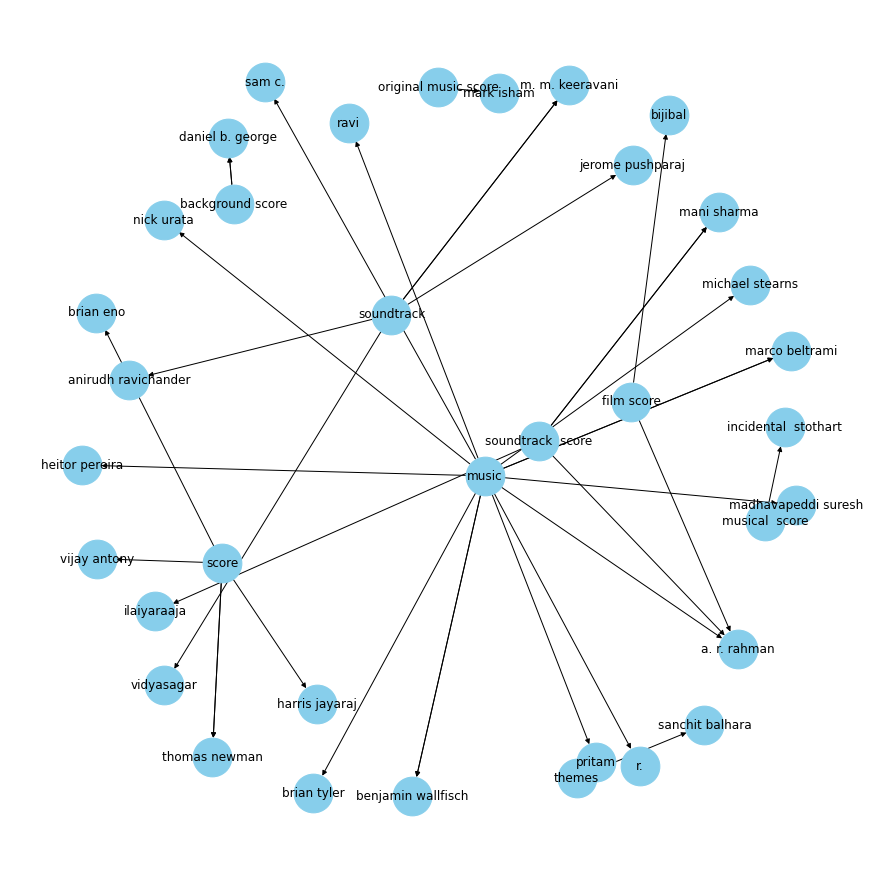

In [ ]:
#visualize the graph for the "composed" by” relation:

G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
#plt.show()

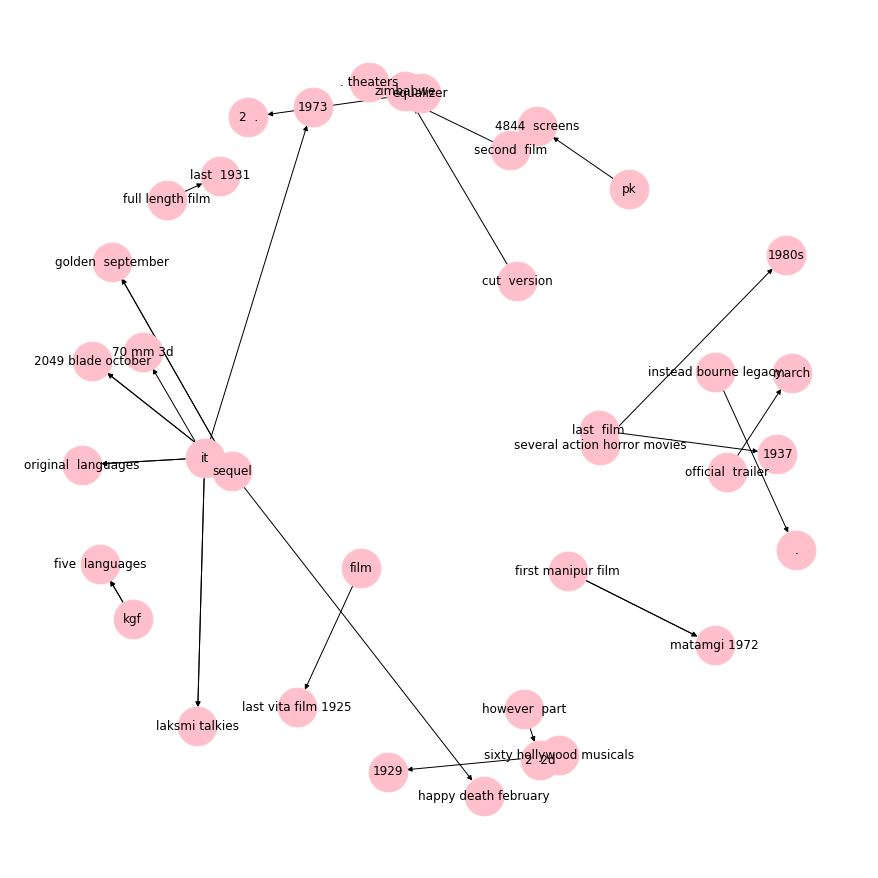

In [ ]:
#visualize the graph for the "released date” relation:

G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='pink', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()